# Cleaning: BJH024


This script cleans the data both by abnormal trials and by noisy channels and epileptic activity. HC electrodes are epileptic :(


### Prep

In [1]:
import matplotlib
matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
from BCI2kReader import BCI2kReader as b2k
import os
import mne
from tabulate import tabulate
import IPython
import seaborn as sns

In [2]:
%matplotlib qt5

In [3]:
# helper functions#

def rle(inarray):
        """ run length encoding. Partial credit to R rle function. 
            Multi datatype arrays catered for including non Numpy
            returns: tuple (runlengths, startpositions, values) """
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]               # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)   # must include last element posi
            z = np.diff(np.append(-1, i))       # run lengths
            p = np.cumsum(np.append(0, z))[:-1] # positions
            return(z, p, ia[i])
        
def find_bad_trial_times(idx, srate, trial_begins, trial_lengths):
    ''' takes and index of trial lengths, beginnings and the sampling rate and returns the the start time and and
    duration of the times to annotae as BAD '''
    start_time = trial_begins[0][idx]/srate
    duration = trial_lengths[0][idx]/srate
    
    return start_time, duration        

In [4]:
## Prep paths ##

subject = 'BJH024'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/{subject}/ieeg"

In [5]:
## Load Data ##

raw_fif = mne.io.Raw(f"{raw_data_dir}/ieeg/{subject}_raw_ieeg.fif")

Opening raw data file /home/brooke/pacman/raw_data/BJH024/ieeg/BJH024_raw_ieeg.fif...
    Range : 0 ... 2085999 =      0.000 ...  1042.999 secs
Ready.
Opening raw data file /home/brooke/pacman/raw_data/BJH024/ieeg/BJH024_raw_ieeg-1.fif...
    Range : 2086000 ... 4171999 =   1043.000 ...  2085.999 secs
Ready.
Opening raw data file /home/brooke/pacman/raw_data/BJH024/ieeg/BJH024_raw_ieeg-2.fif...
    Range : 4172000 ... 4365199 =   2086.000 ...  2182.599 secs
Ready.


In [ ]:
## Filtering ##

# load data #
raw_fif.load_data()

# highpass filter @ 1 and lowpass @ 200 #
filtered_data = raw_fif.filter(l_freq=1, h_freq=150) # skip this step for TF analysis, always do this on the least processed data, or do .1 to 250

# remove 60hz line noise #
freqs = (60, 120, 180, 240)
filtered_notch_data = filtered_data.notch_filter(freqs=freqs) 


In [13]:
## Load/Save Filtered Data ##

# save #
# filtered_notch_data.save(f"{raw_data_dir}/ieeg/{subject}_notched_filtered_ieeg.fif", overwrite = True)

# load #
filtered_notch_data = mne.io.Raw(f"{raw_data_dir}/ieeg/{subject}_notched_filtered_ieeg.fif")
events = mne.find_events(filtered_notch_data, output='step', consecutive = False, stim_channel='STI')

Opening raw data file /home/brooke/pacman/raw_data/BJH024/ieeg/BJH024_notched_filtered_ieeg.fif...
    Range : 0 ... 2085999 =      0.000 ...  1042.999 secs
Ready.
Opening raw data file /home/brooke/pacman/raw_data/BJH024/ieeg/BJH024_notched_filtered_ieeg-1.fif...
    Range : 2086000 ... 4171999 =   1043.000 ...  2085.999 secs
Ready.
Opening raw data file /home/brooke/pacman/raw_data/BJH024/ieeg/BJH024_notched_filtered_ieeg-2.fif...
    Range : 4172000 ... 4365199 =   2086.000 ...  2182.599 secs
Ready.
484 events found
Event IDs: [0 1 2]


In [14]:
filtered_notch_data.info['ch_names']

['AL1',
 'AL2',
 'AL3',
 'AL5',
 'REF1',
 'REF2',
 'AL6',
 'AL7',
 'AL8',
 'AL9',
 'AL11',
 'AL12',
 'AL13',
 'AL14',
 'BL1',
 'BL2',
 'BL3',
 'BL4',
 'BL5',
 'BL6',
 'BL7',
 'BL9',
 'BL10',
 'BL11',
 'BL12',
 'BL14',
 'BL15',
 'BL16',
 'CL1',
 'CL2',
 'CL7',
 'CL8',
 'CL9',
 'CL10',
 'CL12',
 'CL13',
 'CL14',
 'CL15',
 'CL16',
 'DL1',
 'DL2',
 'DL3',
 'DL11',
 'DL12',
 'DL13',
 'DL14',
 'DL15',
 'DL16',
 'EL1',
 'EL2',
 'EL3',
 'EL4',
 'EL5',
 'EL6',
 'EL7',
 'EL8',
 'EL9',
 'EL10',
 'EL11',
 'EL12',
 'FL1',
 'FL2',
 'FL3',
 'FL4',
 'FL5',
 'FL6',
 'FL7',
 'FL8',
 'FL9',
 'FL10',
 'GL1',
 'GL2',
 'GL3',
 'GL4',
 'GL5',
 'GL6',
 'GL7',
 'GL8',
 'GL9',
 'GL10',
 'GL11',
 'GL12',
 'GL13',
 'GL14',
 'HL1',
 'HL2',
 'HL3',
 'HL4',
 'HL5',
 'HL6',
 'HL7',
 'HL8',
 'HL9',
 'HL10',
 'HL11',
 'HL12',
 'HL13',
 'HL14',
 'IL1',
 'IL2',
 'IL3',
 'IL4',
 'IL5',
 'IL6',
 'IL11',
 'IL12',
 'IL13',
 'IL14',
 'JL1',
 'JL2',
 'JL3',
 'JL4',
 'JL5',
 'JL6',
 'JL7',
 'JL8',
 'JL9',
 'JL10',
 'JL11',
 'JL

## Cleaning Neural Data

#### Bad Channels

Epileptic channels from my cleaning: 

Noisy channels: 

In [15]:
# Remove Channels from filtered data

# remove non seeg electrodes electrodes #
string_lst = ['EMPTY', 'REF', 'ekg']

bad_channels_reg = [re.findall(r"(?=("+'|'.join(string_lst)+r"))", name, re.IGNORECASE) for name in filtered_notch_data.info['ch_names']]
bad_channels_index = [i for i,x in enumerate(bad_channels_reg) if  x]
bad_channels = [filtered_notch_data.info['ch_names'][i] for i in bad_channels_index]

filtered_notch_data.info['bads'].extend(bad_channels)  

# # remove epileptic electrodes
# # remove epileptic electrodes
bob_cleaned_bad_channels = ['EL2', 'EL3', 'GL1', 'GL2', 'HL4', 'HL3', 'HL2', 'ER7', 'HL1', 'FL8', 'IR1', 'IR2', 'IR3', 'HR1', 'HR2']
filtered_notch_data.info['bads'].extend(bob_cleaned_bad_channels) 

# remove scalp and dc channels
scalp_dc_channels = [ 'FP1',
 'F3',
 'C3',
 'P3',
 'O1',
 'FP2',
 'F4',
 'C4',
 'P4',
 'O2',
 'F7',
 'T7',
 'P7',
 'F8',
 'T8',
 'P8',
 'F9',
 'F10',
 'FPZ',
 'FZ',
 'CZ',
 'PZ',
 'OZ',
 'EKG1',
 'EKG2']

filtered_notch_data.info['bads'].extend(scalp_dc_channels)
filtered_notch_data

<Raw | BJH024_notched_filtered_ieeg.fif, 257 x 4365200 (2182.6 s), ~258 kB, data not loaded>

In [16]:
# Remove Channels from filtered data

# remove non seeg electrodes electrodes #
string_lst = ['EMPTY', 'REF', 'ekg']

bad_channels_reg = [re.findall(r"(?=("+'|'.join(string_lst)+r"))", name, re.IGNORECASE) for name in raw_fif.info['ch_names']]
bad_channels_index = [i for i,x in enumerate(bad_channels_reg) if  x]
bad_channels = [raw_fif.info['ch_names'][i] for i in bad_channels_index]

raw_fif.info['bads'].extend(bad_channels)  

# # remove epileptic electrodes
bob_cleaned_bad_channels = ['EL2', 'EL3', 'GL1', 'GL2', 'HL4', 'HL3', 'HL2', 'ER7', 'HL1', 'FL8', 'IR1', 'IR2', 'IR3', 'HR1']
raw_fif.info['bads'].extend(bob_cleaned_bad_channels)  


# remove scalp and dc channels
scalp_dc_channels = [ 'FP1',
 'F3',
 'C3',
 'P3',
 'O1',
 'FP2',
 'F4',
 'C4',
 'P4',
 'O2',
 'F7',
 'T7',
 'P7',
 'F8',
 'T8',
 'P8',
 'F9',
 'F10',
 'FPZ',
 'FZ',
 'CZ',
 'PZ',
 'OZ',
 'EKG1',
 'EKG2']

raw_fif.info['bads'].extend(scalp_dc_channels)
raw_fif

<Raw | BJH024_raw_ieeg.fif, 257 x 4365200 (2182.6 s), ~258 kB, data not loaded>

#### Bad Epochs



In [ ]:
# # Annotate Noisy Epochs from Bob's cleaning

# ### Filtered

# onsets = [filtered_notch_data
#     filtered_notch_data.first_time + 78, #2
#     filtered_notch_data.first_time + 173, #2
#     filtered_notch_data.first_time + 414, #2
#     filtered_notch_data.first_time + 438, #1
#     filtered_notch_data.first_time + 475, #.6
#     filtered_notch_data.first_time + 564, #1
#     filtered_notch_data.first_time + 625, #2
#     filtered_notch_data.first_time + 654.5, #1
#     filtered_notch_data.first_time + 690, #1
#     filtered_notch_data.first_time + 736.75, #1
#     filtered_notch_data.first_time + 852, #1
#     filtered_notch_data.first_time + 1391 #2
    
# ]

# ### Raw

# onsets = [
#     raw_fif.first_time + 78, #2
#     raw_fif.first_time + 173, #2
#     raw_fif.first_time + 414, #2
#     raw_fif.first_time + 438, #1
#     raw_fif.first_time + 475, # .6
#     raw_fif.first_time + 564, #1
#     raw_fif.first_time + 625, #2
#     raw_fif.first_time + 654.5, #1
#     raw_fif.first_time + 690, #1
#     raw_fif.first_time + 736.75, #1
#     raw_fif.first_time + 852, #1    
#     raw_fif.first_time + 1391 #2
    
    
# ]


# durations = [2, 2, 2, 1, .6, 1, 2, 1, 1, 1, 1, 2]
# descriptions = ['bad'] * len(durations)


## Cleaning Bad Trials

In [ ]:
# ## quality check trials ##

# # calculate trial onsets and offsets
# sti_raw = filtered_notch_data.get_data(picks = ['STI'])
# lengths, positionsm, val  = rle(sti_raw[0])

# # lengths, beginnings, endings, for trials
# trial_lengths = [lengths[x] for x in np.where(val == 1)]
# trial_begins = [positionsm[x] for x in np.where(val == 1)]
# trial_ends = trial_lengths[0] + trial_begins[0]
# trial_baseline = trial_begins[0] - 1000

# # lengths, beginnings, endings, for itis
# iti_lengths = [lengths[x] for x in np.where(val == 0)]
# iti_begins = [positionsm[x] for x in np.where(val == 0)]
# iti_ends = iti_begins[0] + iti_lengths[0]

# # save trial lengths for later
# np.save(f"{preproc_data_dir}/{subject}_trial_lengths.npy", trial_lengths)

In [ ]:
# # exclude bad trials/apochs from r behavioral analysis (paused trials and no biscuits)

# # load bad trial data
# bad_trials = np.genfromtxt(f"{raw_data_dir}/behave/{subject}_bad_trials.csv", delimiter = ',', skip_header = 1)

# for bad in bad_trials:
#     start, dur = find_bad_trial_times(int(bad), 2000, trial_begins, trial_lengths)
#     onsets.append(start)
#     durations.append(dur)

# # update descriptions
# descriptions = ['bad'] * len(durations)


## Visualizing Neural Data

In [ ]:
## exclude all bad epochs from both bad trials and investigating neural data ##

# # create annotations structure #
# bad_annots = mne.Annotations(onset=onsets,
#                                duration=durations,
#                                description=descriptions,
#                                orig_time=filtered_notch_data.info['meas_date'])

# # apply to filtered data #
# filtered_notch_data.set_annotations(bad_annots)


# # apply to not filtered data #
# raw_fif.set_annotations(bad_annots)

next step, working on filtering out the high frequency noise

then look at Marks script to come up with some plot of every trial, sort longest to shortest, with theta power as the color tiome as x, trial on y

In [17]:
filtered_notch_data.drop_channels(filtered_notch_data.info['bads'])

<Raw | BJH024_notched_filtered_ieeg.fif, 215 x 4365200 (2182.6 s), ~215 kB, data not loaded>

Using matplotlib as 2D backend.
Opening raw-browser...


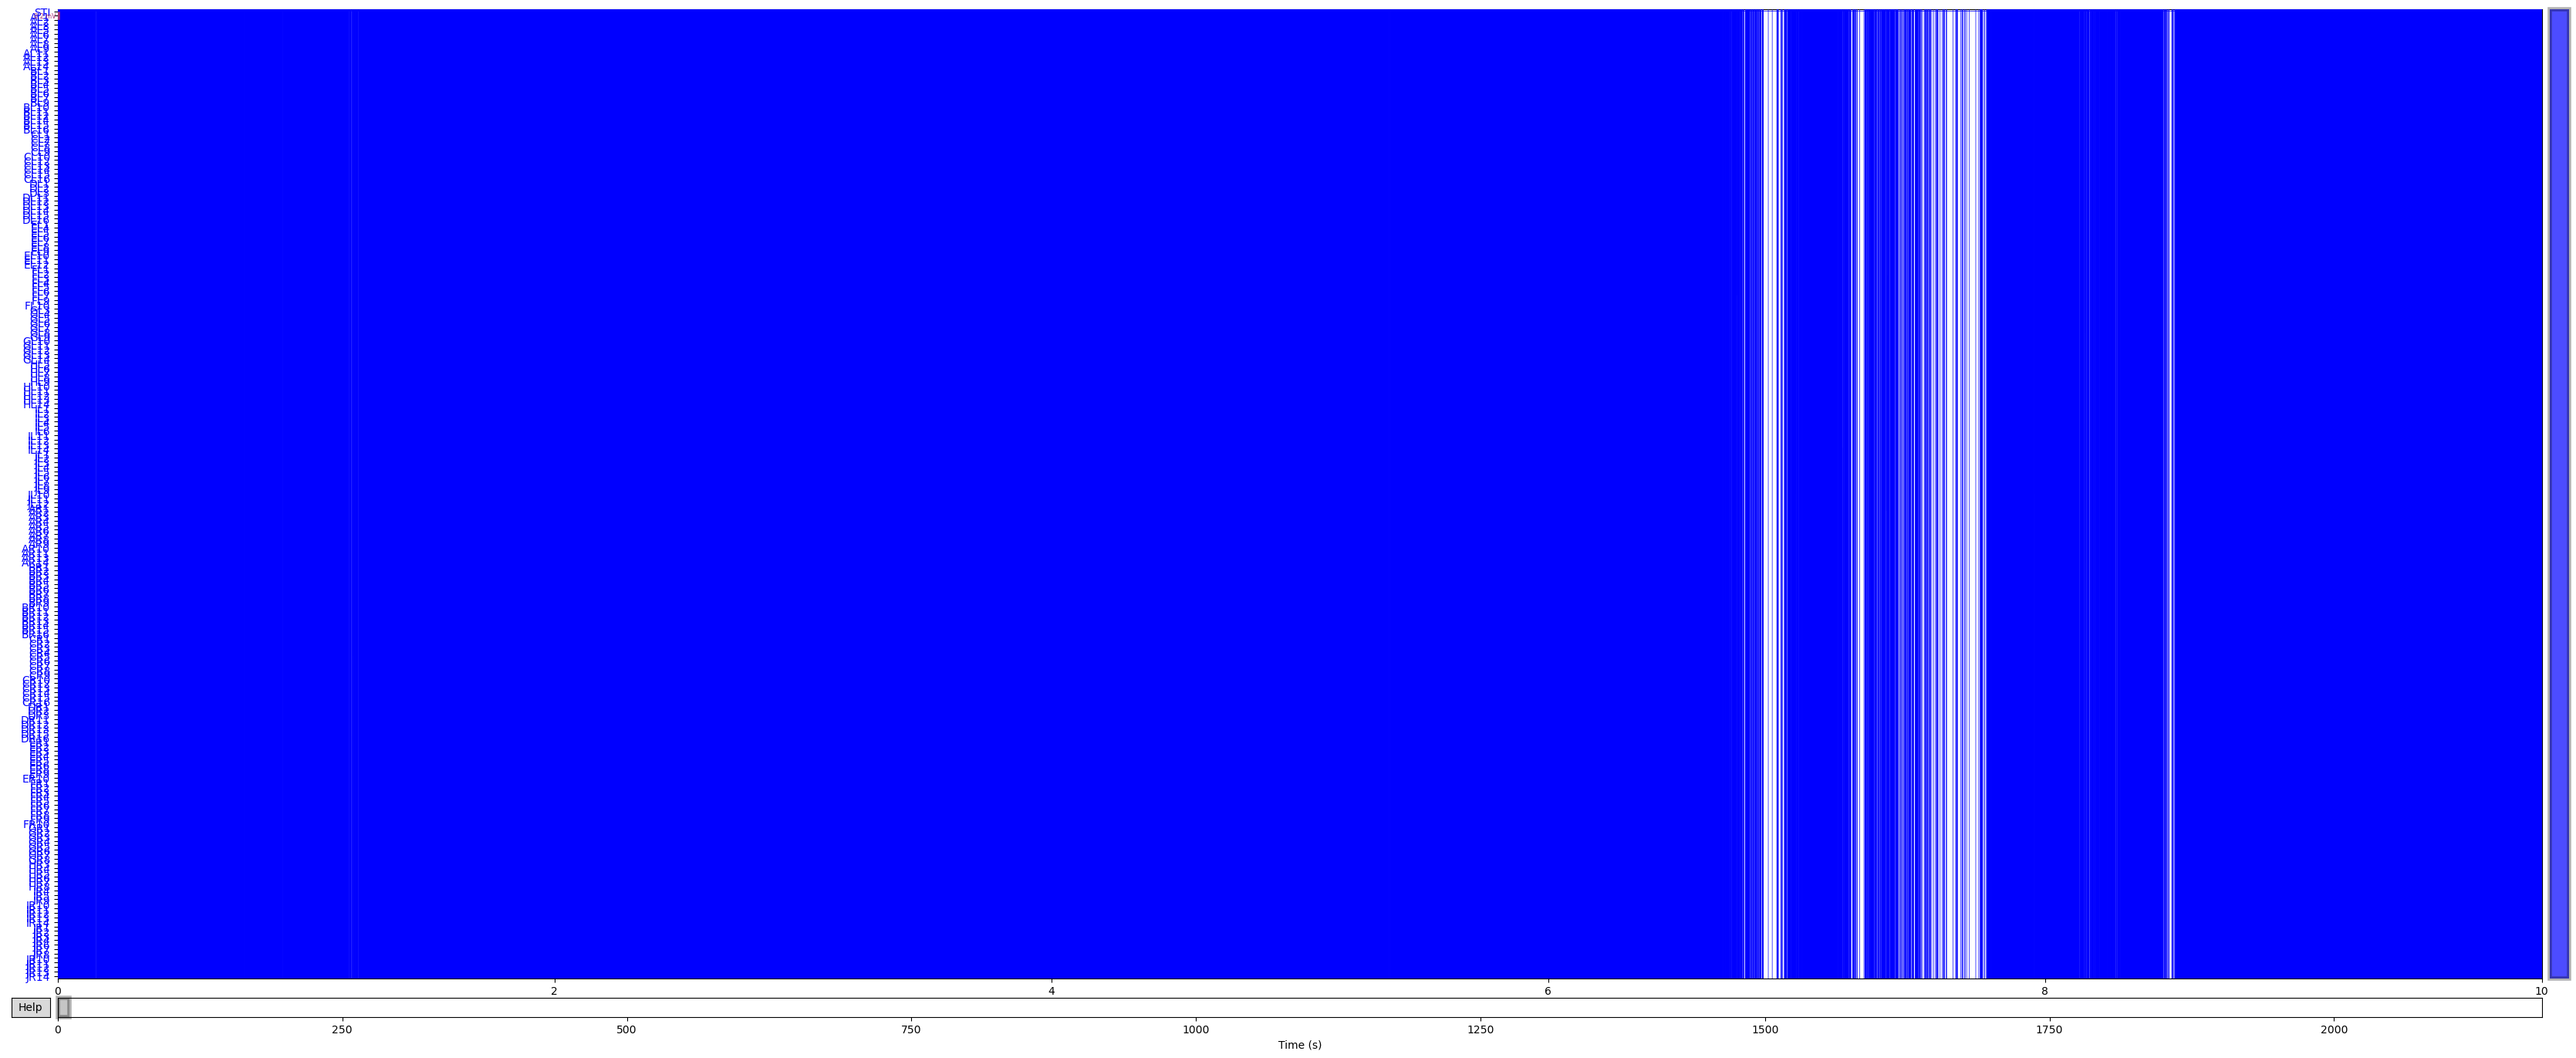

In [18]:
# plot for cleaning #

filtered_notch_data.plot(events=events, color='b', bad_color = 'red', n_channels = 230, clipping = None, event_color = 'r')

In [ ]:
# plot psd of all channels #

filtered_notch_data.plot_psd()

In [ ]:
# plot psd of bad channels #

filtered_notch_data.plot_psd(picks = filtered_notch_data.info['bads'])

In [19]:
filtered_notch_data.annotations

<Annotations | 22 segments: BAD_ (22)>

In [22]:
# From interactive sessions
interactive_annot = filtered_notch_data.annotations
for x in range(0, 22):
    print(interactive_annot[x])
    
    
filtered_notch_data.annotations.save('../ieeg/saved_annotations.fif', overwrite = True)    

OrderedDict([('onset', 123.83442390039933), ('duration', 0.6240581279026145), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 246.75356741913987), ('duration', 0.5588580249874155), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 252.28825003126744), ('duration', 2.7539281564657756), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 312.99303209611264), ('duration', 1.5089166674660532), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 386.38654221450855), ('duration', 0.8879633063688743), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 433.6698712597086), ('duration', 0.5930104598477328), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 443.2383086737461), ('duration', 1.4871832998276204), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 605.0956219450105), ('duration', 1.139449417613264), ('description', 'BAD_'), ('orig_time', None)])
Orde

/tmp/ipykernel_2779/3932287894.py:7: RuntimeWarning: This filename (../ieeg/saved_annotations.fif) does not conform to MNE naming conventions. All annotations files should end with -annot.fif, -annot.fif.gz, _annot.fif, _annot.fif.gz, .txt or .csv
  filtered_notch_data.annotations.save('../ieeg/saved_annotations.fif', overwrite = True)


## Save Files

In [ ]:
# save filtered data #
filtered_notch_data.save(f"{raw_data_dir}/ieeg/{subject}_notched_filtered_clean_ieeg.fif", overwrite = True)


# save raw clean data #
raw_fif.save(f"{raw_data_dir}/ieeg/{subject}_raw_clean_ieeg.fif", overwrite = True)
